In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import matplotlib

In [2]:
import pandas as pd
data=pd.read_csv("US_Accidents_Dec21_updated.csv")
data=data.drop(columns = ['Number','Zipcode','Airport_Code','Country','Wind_Chill(F)', 'Wind_Direction', 
                    'Amenity','Civil_Twilight', 'Nautical_Twilight','Astronomical_Twilight'])
data=data.dropna()
data['Start_Time']=pd.to_datetime(data['Start_Time'])
data['End_Time']=pd.to_datetime(data['End_Time'])
data.insert(4,"time diff(h)",(data['End_Time']-data["Start_Time"]).dt.total_seconds()/3600)
data.insert(3,"Year",pd.DatetimeIndex(data["Start_Time"]).year)
data.insert(4,"Month",pd.DatetimeIndex(data["Start_Time"]).month)
data.insert(5,"Day",pd.DatetimeIndex(data["Start_Time"]).day)
data.loc[:,"Bump":"Turning_Loop"]=data.loc[:,"Bump":"Turning_Loop"].astype(int)
data=data.sort_values(["Year",'Month','Day'])
data['Sunrise_Sunset'] = data['Sunrise_Sunset'].map({'Night':int(0), 'Day':int(1)})
data=data.set_index([pd.Index(range(data.shape[0]))])
df_cleaned =data.drop(columns = ['ID','Start_Time',
                            'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng','Description',
                          'Street','Side','City','County','Timezone','time diff(h)', 'Weather_Timestamp',
                            'Weather_Condition','Turning_Loop'])
df_cleaned

,Severity,Year,Month,Day,Distance(mi),State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset
0,4,2016,1,14,0.061,PA,31.0,69.0,29.53,10.0,...,0,0,0,0,0,0,0,0,0,0
1,4,2016,1,14,0.061,PA,31.0,69.0,29.53,10.0,...,0,0,0,0,0,0,0,0,0,0
2,4,2016,1,14,0.061,PA,31.0,69.0,29.53,10.0,...,0,0,0,0,0,0,0,0,0,0
3,4,2016,1,14,0.061,PA,31.0,69.0,29.53,10.0,...,0,0,0,0,0,0,0,0,0,0
4,4,2016,1,14,0.061,PA,31.0,69.0,29.53,10.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240925,2,2021,12,31,0.022,PA,50.0,86.0,29.49,3.0,...,0,0,0,0,0,0,0,0,0,0
2240926,2,2021,12,31,0.019,CA,46.0,68.0,27.20,10.0,...,0,0,0,0,0,0,0,0,1,1
2240927,2,2021,12,31,2.278,PA,41.0,100.0,28.53,0.5,...,0,0,0,0,0,0,0,0,0,0
2240928,2,2021,12,31,0.162,TX,72.0,76.0,29.05,10.0,...,0,0,0,0,0,0,0,0,0,1


In [3]:
numerical_features=['Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)']

In [4]:
data_numeric=df_cleaned[numerical_features]
data_numeric
scaler=preprocessing.StandardScaler().fit(data_numeric)
data_scaled=scaler.transform(data_numeric)
data_scaled=pd.DataFrame(data_scaled)
data_scaled.columns=numerical_features
data_scaled

,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
0,-0.422251,-1.670626,0.175727,0.136264,0.373201,-0.758921,-0.087405
1,-0.422251,-1.670626,0.175727,0.136264,0.373201,-0.758921,-0.087405
2,-0.422251,-1.670626,0.175727,0.136264,0.373201,-0.758921,-0.087405
3,-0.422251,-1.670626,0.175727,0.136264,0.373201,-0.758921,-0.087405
4,-0.422251,-1.670626,0.175727,0.136264,0.373201,-0.758921,-0.087405
...,...,...,...,...,...,...,...
2240925,-0.448188,-0.641905,0.923349,0.099437,-2.288040,-1.302487,-0.087405
2240926,-0.450184,-0.858478,0.131750,-2.008944,0.373201,5.220314,-0.087405
2240927,1.052200,-1.129194,1.539037,-0.784426,-3.238484,-1.302487,-0.087405
2240928,-0.355079,0.549245,0.483572,-0.305667,0.373201,1.234158,-0.087405


In [5]:
df_cleaned[numerical_features]=data_scaled
df_cleaned

,Severity,Year,Month,Day,Distance(mi),State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset
0,4,2016,1,14,-0.422251,PA,-1.670626,0.175727,0.136264,0.373201,...,0,0,0,0,0,0,0,0,0,0
1,4,2016,1,14,-0.422251,PA,-1.670626,0.175727,0.136264,0.373201,...,0,0,0,0,0,0,0,0,0,0
2,4,2016,1,14,-0.422251,PA,-1.670626,0.175727,0.136264,0.373201,...,0,0,0,0,0,0,0,0,0,0
3,4,2016,1,14,-0.422251,PA,-1.670626,0.175727,0.136264,0.373201,...,0,0,0,0,0,0,0,0,0,0
4,4,2016,1,14,-0.422251,PA,-1.670626,0.175727,0.136264,0.373201,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240925,2,2021,12,31,-0.448188,PA,-0.641905,0.923349,0.099437,-2.288040,...,0,0,0,0,0,0,0,0,0,0
2240926,2,2021,12,31,-0.450184,CA,-0.858478,0.131750,-2.008944,0.373201,...,0,0,0,0,0,0,0,0,1,1
2240927,2,2021,12,31,1.052200,PA,-1.129194,1.539037,-0.784426,-3.238484,...,0,0,0,0,0,0,0,0,0,0
2240928,2,2021,12,31,-0.355079,TX,0.549245,0.483572,-0.305667,0.373201,...,0,0,0,0,0,0,0,0,0,1


In [6]:
data_scaled=df_cleaned[["Severity","Year","State","Temperature(F)","Humidity(%)","Pressure(in)","Bump","Crossing","Station","Roundabout"]]
data_scaled

,Severity,Year,State,Temperature(F),Humidity(%),Pressure(in),Bump,Crossing,Station,Roundabout
0,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
1,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
2,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
3,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
4,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2240925,2,2021,PA,-0.641905,0.923349,0.099437,0,0,0,0
2240926,2,2021,CA,-0.858478,0.131750,-2.008944,0,1,0,0
2240927,2,2021,PA,-1.129194,1.539037,-0.784426,0,0,0,0
2240928,2,2021,TX,0.549245,0.483572,-0.305667,0,0,0,0


In [7]:
data_scaled.Severity.value_counts()

2    2080349
3      71130
4      65895
1      23556
Name: Severity, dtype: int64

# 2016-2021 balanced data

In [8]:
S1=data_scaled[data_scaled["Severity"]==1]
S1
S2=data_scaled[data_scaled["Severity"]==2]
S2
S3=data_scaled[data_scaled["Severity"]==3]
S3
S4=data_scaled[data_scaled["Severity"]==4]
S4

,Severity,Year,State,Temperature(F),Humidity(%),Pressure(in),Bump,Crossing,Station,Roundabout
0,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
1,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
2,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
3,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
4,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2239913,4,2021,CO,-2.320344,0.923349,-8.416949,0,0,0,0
2240129,4,2021,VA,-0.425332,1.099260,-0.149150,0,0,0,0
2240190,4,2021,TX,0.440959,0.571527,-0.379322,0,0,0,0
2240213,4,2021,CO,-0.425332,-1.847248,-4.237015,0,0,0,0


In [9]:
severity_1_sample = S1
#severity_2_sample = S2.sample(n=23556,replace=False,random_state = 2)
severity_2_sample = S2.sample(n=23556,replace=False,random_state = 2)
severity_3_sample = S3.sample(n=23556,replace=False,random_state = 2)
severity_4_sample = S4.sample(n=23556,replace=False,random_state = 2)
severity_4_sample
data_resampling = pd.concat([severity_1_sample,severity_2_sample,severity_3_sample,severity_4_sample])
data_resampling

,Severity,Year,State,Temperature(F),Humidity(%),Pressure(in),Bump,Crossing,Station,Roundabout
303967,1,2020,NC,-0.533619,1.011304,-0.563460,0,0,0,0
303969,1,2020,NC,-0.154616,1.011304,-0.029460,0,0,0,0
303970,1,2020,NC,-0.208759,1.099260,-0.084701,0,0,0,0
303972,1,2020,NC,-0.208759,0.571527,0.255954,0,0,0,0
303974,1,2020,NC,-0.262903,1.231193,0.237540,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
775271,4,2020,MS,-1.129194,0.219705,0.458506,0,0,0,0
1332377,4,2021,CT,0.603389,0.703460,0.458506,0,0,0,0
101015,4,2019,CO,1.307250,-1.759292,-4.384325,0,0,0,0
657077,4,2020,LA,-0.425332,1.231193,0.568989,0,0,0,0


In [10]:
data_resampling.Severity.value_counts()

4    23556
3    23556
2    23556
1    23556
Name: Severity, dtype: int64

In [11]:
X_total=data_resampling[["Temperature(F)","Humidity(%)","Pressure(in)","Bump","Crossing","Station","Roundabout"]]
X_total
Y_total=data_resampling["Severity"]
Y_total

303967     1
303969     1
303970     1
303972     1
303974     1
          ..
775271     4
1332377    4
101015     4
657077     4
212456     4
Name: Severity, Length: 94224, dtype: int64

In [12]:
X_train, X_test, Y_train, Y_test=train_test_split(X_total, Y_total, test_size=0.3, random_state=324)

In [13]:
from sklearn.model_selection import GridSearchCV
logit=LogisticRegression(multi_class="multinomial",solver='lbfgs',max_iter=300)
C=[20,10,5,1,0.5,0.1,0.01,0.001]
param_grid = {'C':C}
logit_gscv = GridSearchCV(logit, param_grid, cv=5)
logit_gscv.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=300,
                                          multi_class='multinomial'),
             param_grid={'C': [20, 10, 5, 1, 0.5, 0.1, 0.01, 0.001]})

In [14]:
best_C_Value = logit_gscv.best_params_
print('Best C value: ', best_C_Value)
print('Best CV accuracy: ', logit_gscv.best_score_)
best_model = logit_gscv.best_estimator_
test_acc = best_model.score(X_test,Y_test)
print("Test set accuracy of best model: {:.6f}".format(test_acc))

Best C value:  {'C': 5}
Best CV accuracy:  0.36304507446892487
Test set accuracy of best model: 0.358674


# 2020 balanced data

In [15]:
data_scaled

,Severity,Year,State,Temperature(F),Humidity(%),Pressure(in),Bump,Crossing,Station,Roundabout
0,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
1,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
2,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
3,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
4,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2240925,2,2021,PA,-0.641905,0.923349,0.099437,0,0,0,0
2240926,2,2021,CA,-0.858478,0.131750,-2.008944,0,1,0,0
2240927,2,2021,PA,-1.129194,1.539037,-0.784426,0,0,0,0
2240928,2,2021,TX,0.549245,0.483572,-0.305667,0,0,0,0


In [16]:
data_2020=data_scaled[data_scaled["Year"]==2020]
data_2020

,Severity,Year,State,Temperature(F),Humidity(%),Pressure(in),Bump,Crossing,Station,Roundabout
249981,2,2020,NH,-1.724769,0.439594,-0.213598,0,0,0,0
249982,2,2020,NH,-1.454053,-0.044161,-0.406943,0,0,0,0
249983,2,2020,NH,-1.670626,0.307661,-0.839667,0,0,0,0
249984,2,2020,ME,-1.454053,0.307661,-0.158356,0,0,0,0
249985,2,2020,NH,-1.508196,0.219705,0.016575,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
823583,2,2020,AL,-0.154616,0.791416,0.458506,0,0,0,0
823584,2,2020,NC,-0.912621,1.539037,0.338816,0,0,0,0
823585,2,2020,TX,-1.237480,1.539037,-0.296460,0,0,0,0
823586,2,2020,CA,-1.129194,1.055282,0.301989,0,0,0,0


In [17]:
data_2020.Severity.value_counts()

2    489028
3     40371
1     23556
4     20652
Name: Severity, dtype: int64

In [18]:
S1_2020=data_2020[data_2020["Severity"]==1]
S2_2020=data_2020[data_2020["Severity"]==2]
S3_2020=data_2020[data_2020["Severity"]==3]
S4_2020=data_2020[data_2020["Severity"]==4]
S1_2020
S2_2020
S3_2020
S4_2020
S1_2020
severity_1_sample_2020 = S1_2020.sample(n=20652,replace=False,random_state = 2)
severity_2_sample_2020 = S2_2020.sample(n=20652,replace=False,random_state = 2)
severity_3_sample_2020 = S3_2020.sample(n=20652,replace=False,random_state = 2)
severity_4_sample_2020 = S4_2020
severity_1_sample_2020
severity_2_sample_2020
severity_3_sample_2020
severity_4_sample_2020
data_resampling_2020= pd.concat([severity_1_sample_2020,severity_2_sample_2020,severity_3_sample_2020,severity_4_sample_2020])
data_resampling_2020

,Severity,Year,State,Temperature(F),Humidity(%),Pressure(in),Bump,Crossing,Station,Roundabout
436766,1,2020,OR,-0.371189,0.923349,0.338816,0,1,1,0
428087,1,2020,TN,-0.154616,1.275171,0.274368,0,1,0,0
352473,1,2020,NY,-0.912621,0.747438,0.661058,0,0,0,0
414753,1,2020,AZ,1.686253,-2.594869,-2.091806,0,1,0,0
455526,1,2020,OR,1.577966,-1.891226,0.274368,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
822520,4,2020,FL,0.603389,0.615505,0.651851,0,1,0,0
822527,4,2020,GA,-0.966764,1.539037,-0.296460,0,0,0,0
822540,4,2020,GA,-0.425332,1.539037,-0.287253,0,0,0,0
822583,4,2020,IA,-2.157915,0.571527,0.044195,0,0,0,0


In [19]:
X_2020=data_resampling_2020[["Temperature(F)","Humidity(%)","Pressure(in)","Bump","Crossing","Station","Roundabout"]]
X_2020
Y_2020=data_resampling_2020['Severity']
Y_2020

436766    1
428087    1
352473    1
414753    1
455526    1
         ..
822520    4
822527    4
822540    4
822583    4
823263    4
Name: Severity, Length: 82608, dtype: int64

In [20]:
X_train0, X_test0, Y_train0, Y_test0=train_test_split(X_2020, Y_2020, test_size=0.3, random_state=324)

In [21]:
from sklearn.model_selection import GridSearchCV
logit=LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=300)
C=[50,20,10,5,1,0.5,0.1,0.01,0.001]
param_grid = {'C':C}
logit_gscv = GridSearchCV(logit, param_grid, cv=5)
logit_gscv.fit(X_train0, Y_train0)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=300,
                                          multi_class='multinomial'),
             param_grid={'C': [50, 20, 10, 5, 1, 0.5, 0.1, 0.01, 0.001]})

In [22]:
best_C_Value = logit_gscv.best_params_
print('Best C value: ', best_C_Value)
print('Best CV accuracy: ', logit_gscv.best_score_)
best_model = logit_gscv.best_estimator_
test_acc = best_model.score(X_test0,Y_test0)
print("Test set accuracy of best model: {:.6f}".format(test_acc))

Best C value:  {'C': 10}
Best CV accuracy:  0.36183311716385647
Test set accuracy of best model: 0.362708


In [23]:
matrix = confusion_matrix(Y_test0,best_model.predict(X_test0) )
print(matrix)

[[2990 1578 1362  153]
 [ 960 2875 1603  680]
 [1480 1860 2435  526]
 [1056 2760 1776  689]]


Text(0.5, 1.0, 'Confusion matrix for 2020 test data')

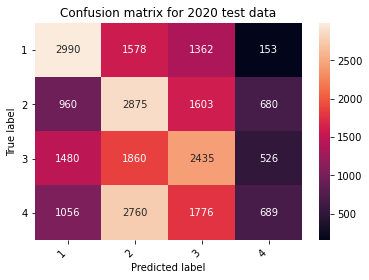

In [24]:
df_cm = pd.DataFrame(
        matrix, index=['1','2','3','4'], columns=['1','2','3','4'], 
    )
heatmap = sns.heatmap(df_cm, annot=True, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion matrix for 2020 test data")

# CA balanced data

In [25]:
data_scaled

,Severity,Year,State,Temperature(F),Humidity(%),Pressure(in),Bump,Crossing,Station,Roundabout
0,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
1,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
2,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
3,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
4,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2240925,2,2021,PA,-0.641905,0.923349,0.099437,0,0,0,0
2240926,2,2021,CA,-0.858478,0.131750,-2.008944,0,1,0,0
2240927,2,2021,PA,-1.129194,1.539037,-0.784426,0,0,0,0
2240928,2,2021,TX,0.549245,0.483572,-0.305667,0,0,0,0


In [26]:
data_CA=data_scaled[data_scaled["State"]=='CA']
data_CA.Severity.value_counts()

2    595406
3      6292
4      4213
1      4189
Name: Severity, dtype: int64

In [27]:
S1_CA=data_CA[data_CA["Severity"]==1]
S2_CA=data_CA[data_CA["Severity"]==2]
S3_CA=data_CA[data_CA["Severity"]==3]
S4_CA=data_CA[data_CA["Severity"]==4]
S1_CA
S2_CA
S3_CA
S4_CA
severity_1_sample_CA = S1_CA
severity_2_sample_CA = S2_CA.sample(n=4189,replace=False,random_state = 2)
severity_3_sample_CA = S3_CA.sample(n=4189,replace=False,random_state = 2)
severity_4_sample_CA = S4_CA.sample(n=4189,replace=False,random_state = 2)
severity_1_sample_CA
severity_2_sample_CA
severity_3_sample_CA
severity_4_sample_CA
data_resampling_CA= pd.concat([severity_1_sample_CA,severity_2_sample_CA,severity_3_sample_CA,severity_4_sample_CA])
data_resampling_CA

,Severity,Year,State,Temperature(F),Humidity(%),Pressure(in),Bump,Crossing,Station,Roundabout
334630,1,2020,CA,-0.533619,0.087772,0.375644,0,0,0,0
334631,1,2020,CA,-0.533619,-0.176094,0.062609,0,0,0,0
334633,1,2020,CA,-0.587762,0.131750,0.375644,0,0,0,0
334635,1,2020,CA,-0.533619,-0.176094,0.062609,0,0,0,0
334638,1,2020,CA,-0.371189,-0.132117,0.403265,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2228402,4,2021,CA,-0.317046,1.231193,0.357230,0,0,0,0
704309,4,2020,CA,-1.129194,-0.132117,0.605817,0,0,0,0
1049839,4,2021,CA,-1.345767,1.055282,-0.158356,0,0,0,0
334911,4,2020,CA,-0.317046,0.967327,-0.121529,0,0,0,0


In [28]:
X_CA=data_resampling_CA[["Temperature(F)","Humidity(%)","Pressure(in)","Bump","Crossing","Station","Roundabout"]]
X_CA
Y_CA=data_resampling_CA['Severity']
Y_CA

334630     1
334631     1
334633     1
334635     1
334638     1
          ..
2228402    4
704309     4
1049839    4
334911     4
1525667    4
Name: Severity, Length: 16756, dtype: int64

In [29]:
X_train_CA, X_test_CA, Y_train_CA, Y_test_CA=train_test_split(X_CA, Y_CA, test_size=0.3, random_state=324)

In [30]:
from sklearn.model_selection import GridSearchCV
logit=LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=300)
C=[50,20,10,5,1,0.5,0.1,0.01,0.001]
#class_weight=["balanced","none"]
param_grid = {'C':C}
logit_gscv = GridSearchCV(logit, param_grid, cv=5)
logit_gscv.fit(X_train_CA, Y_train_CA)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=300,
                                          multi_class='multinomial'),
             param_grid={'C': [50, 20, 10, 5, 1, 0.5, 0.1, 0.01, 0.001]})

In [31]:
best_C_Value = logit_gscv.best_params_
print('Best C value: ', best_C_Value)
print('Best CV accuracy: ', logit_gscv.best_score_)
best_model = logit_gscv.best_estimator_
test_acc = best_model.score(X_test_CA,Y_test_CA)
print("Test set accuracy of best model: {:.6f}".format(test_acc))

Best C value:  {'C': 0.01}
Best CV accuracy:  0.3639691931282571
Test set accuracy of best model: 0.360056


In [32]:
matrix = confusion_matrix(Y_test_CA,best_model.predict(X_test_CA) )
print(matrix)

[[810 101 330  36]
 [515 246 363 106]
 [405 136 639  74]
 [468 202 481 115]]


Text(0.5, 1.0, 'Confusion matrix for CA test data')

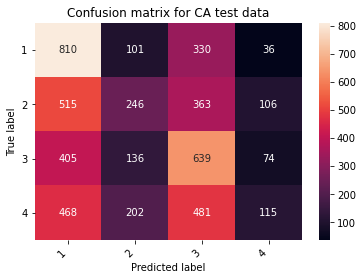

In [33]:
df_cm = pd.DataFrame(
        matrix, index=['1','2','3','4'], columns=['1','2','3','4'], 
    )
#df_cm
heatmap = sns.heatmap(df_cm, annot=True, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion matrix for CA test data")

# Imblanced data

# 2016-2021 imbalanced data with more cases on 2

In [34]:
data_scaled.Severity.value_counts()

2    2080349
3      71130
4      65895
1      23556
Name: Severity, dtype: int64

In [35]:
S1=data_scaled[data_scaled["Severity"]==1]
S1
S2=data_scaled[data_scaled["Severity"]==2]
S2
S3=data_scaled[data_scaled["Severity"]==3]
S3
S4=data_scaled[data_scaled["Severity"]==4]
S4

,Severity,Year,State,Temperature(F),Humidity(%),Pressure(in),Bump,Crossing,Station,Roundabout
0,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
1,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
2,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
3,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
4,4,2016,PA,-1.670626,0.175727,0.136264,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2239913,4,2021,CO,-2.320344,0.923349,-8.416949,0,0,0,0
2240129,4,2021,VA,-0.425332,1.099260,-0.149150,0,0,0,0
2240190,4,2021,TX,0.440959,0.571527,-0.379322,0,0,0,0
2240213,4,2021,CO,-0.425332,-1.847248,-4.237015,0,0,0,0


In [36]:
severity_1_sample = S1
#severity_2_sample = S2.sample(n=23556,replace=False,random_state = 2)
severity_2_sample = S2.sample(n=400000,replace=False,random_state = 2)
severity_3_sample = S3
severity_4_sample = S4
severity_4_sample
data_resampling = pd.concat([severity_1_sample,severity_2_sample,severity_3_sample,severity_4_sample])
data_resampling

,Severity,Year,State,Temperature(F),Humidity(%),Pressure(in),Bump,Crossing,Station,Roundabout
303967,1,2020,NC,-0.533619,1.011304,-0.563460,0,0,0,0
303969,1,2020,NC,-0.154616,1.011304,-0.029460,0,0,0,0
303970,1,2020,NC,-0.208759,1.099260,-0.084701,0,0,0,0
303972,1,2020,NC,-0.208759,0.571527,0.255954,0,0,0,0
303974,1,2020,NC,-0.262903,1.231193,0.237540,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2239913,4,2021,CO,-2.320344,0.923349,-8.416949,0,0,0,0
2240129,4,2021,VA,-0.425332,1.099260,-0.149150,0,0,0,0
2240190,4,2021,TX,0.440959,0.571527,-0.379322,0,0,0,0
2240213,4,2021,CO,-0.425332,-1.847248,-4.237015,0,0,0,0


In [37]:
data_resampling.Severity.value_counts()

2    400000
3     71130
4     65895
1     23556
Name: Severity, dtype: int64

In [38]:
X_total=data_resampling[["Temperature(F)","Humidity(%)","Pressure(in)","Bump","Crossing","Station","Roundabout"]]
X_total
Y_total=data_resampling["Severity"]
Y_total

303967     1
303969     1
303970     1
303972     1
303974     1
          ..
2239913    4
2240129    4
2240190    4
2240213    4
2240656    4
Name: Severity, Length: 560581, dtype: int64

In [39]:
X_train, X_test, Y_train, Y_test=train_test_split(X_total, Y_total, test_size=0.3, random_state=324)

In [40]:
from sklearn.model_selection import GridSearchCV
logit=LogisticRegression(multi_class="multinomial",solver='lbfgs',max_iter=300)
C=[50,20,10,5,1,0.5,0.1,0.01,0.001]
param_grid = {'C':C}
logit_gscv = GridSearchCV(logit, param_grid, cv=5)
logit_gscv.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=300,
                                          multi_class='multinomial'),
             param_grid={'C': [50, 20, 10, 5, 1, 0.5, 0.1, 0.01, 0.001]})

In [41]:
best_C_Value = logit_gscv.best_params_
print('Best C value: ', best_C_Value)
print('Best CV accuracy: ', logit_gscv.best_score_)
best_model = logit_gscv.best_estimator_
test_acc = best_model.score(X_test,Y_test)
print("Test set accuracy of best model: {:.6f}".format(test_acc))

Best C value:  {'C': 20}
Best CV accuracy:  0.7152744864167996
Test set accuracy of best model: 0.713828


In [42]:
matrix = confusion_matrix(Y_test,best_model.predict(X_test) )
print(matrix)

[[   259   6791      1      0]
 [    48 119758     22      0]
 [     7  21451     31      0]
 [    23  19763     21      0]]


# 2020 Imbalanced data

In [43]:
data_2020=data_resampling[data_resampling["Year"]==2020]

In [44]:
data_2020.Severity.value_counts()

2    93909
3    40371
1    23556
4    20652
Name: Severity, dtype: int64

In [45]:
X_2020=data_2020[["Temperature(F)","Humidity(%)","Pressure(in)","Bump","Crossing","Station","Roundabout"]]
X_2020
Y_2020=data_2020['Severity']
Y_2020

303967    1
303969    1
303970    1
303972    1
303974    1
         ..
822520    4
822527    4
822540    4
822583    4
823263    4
Name: Severity, Length: 178488, dtype: int64

In [46]:
X_train0, X_test0, Y_train0, Y_test0=train_test_split(X_2020, Y_2020, test_size=0.3, random_state=324)

In [47]:
from sklearn.model_selection import GridSearchCV
logit=LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=300)
C=[50,20,10,5,1,0.5,0.1,0.01,0.001]
param_grid = {'C':C}
logit_gscv = GridSearchCV(logit, param_grid, cv=5)
logit_gscv.fit(X_train0, Y_train0)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=300,
                                          multi_class='multinomial'),
             param_grid={'C': [50, 20, 10, 5, 1, 0.5, 0.1, 0.01, 0.001]})

In [48]:
best_C_Value = logit_gscv.best_params_
print('Best C value: ', best_C_Value)
print('Best CV accuracy: ', logit_gscv.best_score_)
best_model = logit_gscv.best_estimator_
test_acc = best_model.score(X_test0,Y_test0)
print("Test set accuracy of best model: {:.6f}".format(test_acc))

Best C value:  {'C': 0.001}
Best CV accuracy:  0.549963567770043
Test set accuracy of best model: 0.550096


In [49]:
matrix = confusion_matrix(Y_test0,best_model.predict(X_test0) )
print(matrix)

[[ 1722  5099   225     0]
 [  573 27243   363     0]
 [  360 11312   491     0]
 [  149  5871   139     0]]


Text(0.5, 1.0, 'Confusion matrix for 2020* test data')

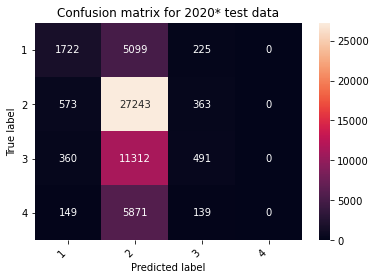

In [50]:
df_cm = pd.DataFrame(
        matrix, index=['1','2','3','4'], columns=['1','2','3','4'], 
    )
heatmap = sns.heatmap(df_cm, annot=True, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion matrix for 2020* test data")

# Imbalanced data in CA

In [51]:
data_CA=data_resampling[data_resampling["State"]=="CA"]

In [52]:
data_CA.Severity.value_counts()

2    114279
3      6292
4      4213
1      4189
Name: Severity, dtype: int64

In [53]:
X_CA=data_CA[["Temperature(F)","Humidity(%)","Pressure(in)","Bump","Crossing","Station","Roundabout"]]
X_CA
Y_CA=data_CA['Severity']
Y_CA

334630     1
334631     1
334633     1
334635     1
334638     1
          ..
2234714    4
2235649    4
2237200    4
2238635    4
2238892    4
Name: Severity, Length: 128973, dtype: int64

In [54]:
X_train_CA, X_test_CA, Y_train_CA, Y_test_CA=train_test_split(X_CA, Y_CA, test_size=0.3, random_state=324)

In [55]:
from sklearn.model_selection import GridSearchCV
logit=LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=300)
C=[50,20,10,5,1,0.5,0.1,0.01,0.001]
#class_weight=["balanced","none"]
param_grid = {'C':C}
logit_gscv = GridSearchCV(logit, param_grid, cv=5)
logit_gscv.fit(X_train_CA, Y_train_CA)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=300,
                                          multi_class='multinomial'),
             param_grid={'C': [50, 20, 10, 5, 1, 0.5, 0.1, 0.01, 0.001]})

In [56]:
best_C_Value = logit_gscv.best_params_
print('Best C value: ', best_C_Value)
print('Best CV accuracy: ', logit_gscv.best_score_)
best_model = logit_gscv.best_estimator_
test_acc = best_model.score(X_test_CA,Y_test_CA)
print("Test set accuracy of best model: {:.6f}".format(test_acc))

Best C value:  {'C': 50}
Best CV accuracy:  0.88538009123818
Test set accuracy of best model: 0.887574


In [57]:
matrix = confusion_matrix(Y_test_CA,best_model.predict(X_test_CA) )
print(matrix)

[[    0  1265     0     0]
 [    1 34342     0     0]
 [    0  1853     0     0]
 [    0  1231     0     0]]


Text(0.5, 1.0, 'Confusion matrix for CA test data')

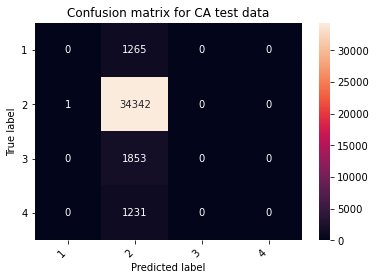

In [58]:
df_cm = pd.DataFrame(
        matrix, index=['1','2','3','4'], columns=['1','2','3','4'], 
    )
#df_cm
heatmap = sns.heatmap(df_cm, annot=True, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion matrix for CA test data")